# Big EO-data Visualization in Browser Notebooks

Authors: 
1. Dr. Rajat Shinde (rajat.shinde@uah.edu) - NASA IMPACT/University of Alabama in Huntsville
2. Dr. Alex Mandel (alex@developmentseed.org) - Development Seed
3. Chuck Daniels (chuck@developmentseed.org) - Development Seed

Acknowledgments:
NASA-ESA Multimission Algorithm and Analysis Platform (MAAP) Science Working Group
1. Dr. Laura Duncanson - University of Maryland
2. Dr. David Minor - University of Maryland
3. Dr. Neha Hunka - University of Maryland
4. Paromita Basak - University of Maryland

Additional Support:
1. Jamison French - Development Seed
2. Sheyenne Kirkland - Development Seed
3. Dr. Brian M. Freitag - NASA 
4. Kyle Barron (Lonboard - kyle@developmentseed.org) - Development Seed
5. Sanjay Bhangar (NotebookSharing.space) - Development Seed
6. Yuvi Panda - 2i2c.org

This presentation illustrates processing and visualizing EO data - Cloud-Optimized GeoTIFFs (COGs) and Cloud-Optimized Point Clouds (COPCs) using [Lonboard](https://developmentseed.org/lonboard/latest/). Lonboard is capable of visualizing big raster and vector datasets including widely used image formats such as COGs and LiDAR data files such as COPCs, LAS file formats.

In this tutorial, Airborne LiDAR Scanning (ALS) based point cloud for Panama, Barro Colorado Island (BCI) is used for visualization along with the Above-ground Biomass (AGB) Estimate and [Meta's Canopy Height Model (CHM)](https://www.sciencedirect.com/science/article/pii/S003442572300439X?via%3Dihub) products. The BCI is an important Smithsonian Tropical Research Institute (STRI) research site for studying the tropical forests.  

We created COGs for these products and use [TiTiler](https://developmentseed.org/titiler/) for dynamically serving tiles from the generated COGs for visualization. The point cloud represents normalized canopy cover heights generated from the raw point cloud data.

Additional Resources:
1. [Lonboard](https://developmentseed.org/lonboard/latest/)
2. [TiTiler](https://developmentseed.org/titiler/)
3. [Converting LiDAR LAS Files to Cloud-Optimized Point Clouds (COPCs)](https://guide.cloudnativegeo.org/copc/lidar-las-to-copc.html)
4. [Introduction to Cloud-Optimized GeoTIFFs](https://guide.cloudnativegeo.org/cloud-optimized-geotiffs/intro.html)
5. [PDAL](https://pdal.io/en/2.6.0/about.html#what-is-pdal)
6. [Barro Colorado Island](https://stri.si.edu/facility/barro-colorado)


### Installing Packages

Install the required packages by executing the following commands in your conda environment. 

In [2]:
# conda install conda-forge::lonboard
# conda install conda-forge::python-pdal

### Importing Packages

We import the required packages for this tutorial.

In [ ]:
%%capture

import geopandas as gpd
from lonboard import viz
import pdal
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from lonboard import Map, BitmapLayer, BitmapTileLayer, PointCloudLayer, PolygonLayer
from lonboard.colormap import apply_continuous_cmap
import httpx
import json
from palettable.colorbrewer.sequential import YlGnBu_7, Greens_3
from palettable.colorbrewer.diverging import Spectral_9
from matplotlib.colors import Normalize

Next, we define the path to the ALS LiDAR file in COPC format to be visualized.

In [2]:
in_file = "s3://maap-ops-workspace/shared/omshinde23/norm_chunk.copc.laz"

In [3]:
# Set AWS region for accessing file

REGION = "us-west-2"
!aws configure set default.region $REGION

### Reading the COPC file

We read the COPC file using the PDAL python package. PDAL processes point cloud data by executing pipelines comprising of various operations (separated by `|` below). For more details, the readers are recommended to follow [Converting LiDAR LAS Files to Cloud-Optimized Point Clouds (COPCs)](https://guide.cloudnativegeo.org/copc/lidar-las-to-copc.html).

In [4]:
# Read the file and get info

info = (pdal.Reader.copc(filename=in_file) | pdal.Filter.info())

info.execute()
metadata = info.metadata

# Get number of points in the COPC file
metadata['metadata']['readers.copc']["count"]

Curl failure: Timeout was reached


71265473

In [9]:
metadata["metadata"]["filters.info"]

{'bbox': {'maxx': 626799.99,
  'maxy': 1012399.99,
  'maxz': 55.03,
  'minx': 625600,
  'miny': 1011600,
  'minz': -10.68},
 'dimensions': 'X, Y, Z, Intensity, ReturnNumber, NumberOfReturns, ScanDirectionFlag, EdgeOfFlightLine, Classification, ScanAngleRank, UserData, PointSourceId, GpsTime, ScanChannel, ClassFlags, TargetThick, DevRatio, Zref',
 'num_points': 71265473,
 'schema': {'dimensions': [{'name': 'X', 'size': 8, 'type': 'floating'},
   {'name': 'Y', 'size': 8, 'type': 'floating'},
   {'name': 'Z', 'size': 8, 'type': 'floating'},
   {'name': 'Intensity', 'size': 2, 'type': 'unsigned'},
   {'name': 'ReturnNumber', 'size': 1, 'type': 'unsigned'},
   {'name': 'NumberOfReturns', 'size': 1, 'type': 'unsigned'},
   {'name': 'ScanDirectionFlag', 'size': 1, 'type': 'unsigned'},
   {'name': 'EdgeOfFlightLine', 'size': 1, 'type': 'unsigned'},
   {'name': 'Classification', 'size': 1, 'type': 'unsigned'},
   {'name': 'ScanAngleRank', 'size': 4, 'type': 'floating'},
   {'name': 'UserData', 

### Subsetting based on a Bounding box

Also, we crop a subset of points by using a spatial filter based on `x` and `y` coordinates, thus reducing the number of points for visualization to save memory.

In [10]:
minx = metadata['metadata']['filters.info']['bbox']['minx']
maxx = metadata['metadata']['filters.info']['bbox']['maxx']
miny = metadata['metadata']['filters.info']['bbox']['miny']
maxy = metadata['metadata']['filters.info']['bbox']['maxy']

# Calculate the center point
center_x = (minx + maxx) / 2
center_y = (miny + maxy) / 2

# Define the distance (e.g., 150 units)
distance = 150

# Define the new bounding box
new_minx = center_x - distance / 2
new_maxx = center_x + distance / 2
new_miny = center_y - distance / 2
new_maxy = center_y + distance / 2

# Create the bounding box string
bounds = f"([{new_minx},{new_maxx}],[{new_miny},{new_maxy}],[-9999,9999])"
bounds

'([626124.995,626274.995],[1011924.995,1012074.995],[-9999,9999])'

In [11]:
del metadata

In [12]:
# Crop the LiDAR file based on spatial bounds using filter.crop 

pipeline = (pdal.Reader.copc(filename=in_file) | pdal.Filter.crop(bounds=bounds))
pipeline.execute()

Curl failure: Timeout was reached


1654874

### Getting the Data Values

The data values from an executed pipeline are retrieved by calling the `arrays` method.

In [13]:
# Getting array values
arr_values = pipeline.arrays

### Creating Geo-dataframe

Now, we will create a data frame followed by a Geo-dataframe based on the data values. Lonboard requires the vector data as Geo-dataframe for visualization.

In [14]:
df = pd.DataFrame(arr_values[0])

In [15]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.X, df.Y, z=df.Z), crs="32617")

Also, Lonboard requires the Geo-dataframe to have its Spatial Reference System (SRS) as World Geodetic System 1984 (WGS 84). So, we re-project the geo-dataframe to `EPSG 4326`, which is the unique reference code for WGS 84.

In [16]:
gdf_proj = gdf.to_crs(4326)
gdf_proj.head()

,X,Y,Z,Intensity,ReturnNumber,NumberOfReturns,ScanDirectionFlag,EdgeOfFlightLine,Classification,ScanAngleRank,UserData,PointSourceId,GpsTime,ScanChannel,ClassFlags,TargetThick,DevRatio,Zref,geometry
0,626267.93,1012074.62,28.54,17,1,3,0,0,1,-15.522,3,15,3.691531e+08,0,0,0.392,1.0,178.00,POINT Z (-79.85080 9.15396 28.54000)
1,626267.79,1012074.43,29.71,16,1,3,0,0,1,-15.576,3,15,3.691531e+08,0,0,0.176,0.7,179.15,POINT Z (-79.85080 9.15395 29.71000)
2,626267.77,1012074.23,29.04,31,2,3,0,0,1,-15.576,3,15,3.691531e+08,0,0,0.080,0.7,178.46,POINT Z (-79.85080 9.15395 29.04000)
3,626267.51,1012073.79,30.26,10,1,4,0,0,1,-15.666,1,15,3.691531e+08,0,0,0.184,1.1,179.64,POINT Z (-79.85080 9.15395 30.26000)
4,626267.42,1012073.80,27.71,12,3,3,0,0,1,-15.588,1,15,3.691531e+08,0,0,0.280,1.2,177.08,POINT Z (-79.85080 9.15395 27.71000)


In order to save memory, we delete the unrequired data frames to keep the memory in check for notebook sharing to be discussed in following section. Also, we drop the columns which are not relevant for the visualization to reduce the memory footprint for lonboard and notebook sharing. 

In [17]:
# Deleting not required dataframes
del(df)
del(gdf)

In [18]:
#Dropping not required columns

gdf_proj = gdf_proj.drop(['ReturnNumber', 'NumberOfReturns', 'ScanDirectionFlag', 'EdgeOfFlightLine', 'ScanAngleRank', 'UserData', 'PointSourceId', 'GpsTime', 'Intensity', 'Classification', 'ScanChannel', 'ClassFlags', 'TargetThick', 'DevRatio', 'Zref'], axis=1)

### Define a Point Cloud Layer

We define a Point Cloud Layer based on the geo-dataframe.

In [19]:
point_layer = PointCloudLayer.from_geopandas(gdf_proj, point_size=2)

### Styling Point Cloud Layer

Here, we normalize the elevation values and create a color map for visualizing the point cloud layer. 

In [20]:
normalizer = Normalize(1, gdf_proj["Z"].max(), clip=True)
normalized_heights = normalizer(gdf_proj["Z"])

In [21]:
point_layer.get_color = apply_continuous_cmap(normalized_heights, Greens_3, alpha=0.6)

### Reading AGB Product - Raster Layer

For visualizing COGs, we use `BitmapTileLayer` which renders tiles dynamically generated by TiTiler.

In [22]:
titiler_endpoint = "https://titiler.maap-project.org"

In [23]:
#AGB product stored locally in MAAP workspace
agb_product_url = "s3://maap-ops-workspace/shared/omshinde23/agbd.tif"

In [24]:
agb_product_tile_url = "https://titiler.maap-project.org/cog/tiles/{z}/{x}/{y}?url=s3://maap-ops-workspace/shared/omshinde23/agbd.tif&bidx=5&rescale=0,600&colormap_name=viridis"

In [25]:
r_agb = httpx.get(
    f"{titiler_endpoint}/cog/info",
    params = {
        "url": agb_product_url,
    }
).json()

bounds_agb = r_agb["bounds"]
print(bounds_agb)

[-79.87926821173158, 9.121956517182756, -79.81171917965493, 9.186829702218509]


In [26]:
agb_product_layer = BitmapTileLayer(
    data=agb_product_tile_url,
    tile_size=148,
    max_requests=-1,
    min_zoom=3,
    max_zoom=18,
    extent=bounds_agb
)

### Reading BCI Trails 2024 layer

In addition to the point cloud layer and the AGB product layer, we add the BCI Trails 2022 layer downloaded locally for the visualization. 

Source: [BCI Trails 2024](https://arcg.is/0bLP0f)

In [27]:
url = "https://opendata.arcgis.com/datasets/647044233eb04328be4e714e82c6447f_0.geojson"
gdf_trail = gpd.read_file(url)
gdf_trail.head()

,OBJECTID,NAME,FullName,TYPE,LABEL,GlobalID,SHAPE_Length,geometry
0,1,Harvard,Harvard University,Official Trail,Harvard,{57C9F376-C503-4CC7-A726-7DBFB94D7EAB},0.017940,"MULTILINESTRING ((-79.83224 9.15324, -79.83207..."
1,2,Chapman,Frank M. Chapman,Official Trail,Chapman,{CC890B54-0CEF-478D-A430-8B91C3417392},0.009092,"MULTILINESTRING ((-79.83208 9.15386, -79.83197..."
2,3,T. Barbour,Thomas Barbour,Official Trail,T. Barbour,{DE8E8F6C-EC5F-40AE-9B80-A07DAEA0FD23},0.026124,"MULTILINESTRING ((-79.83896 9.16169, -79.83890..."
3,4,Hood,J. Douglas Hood,Official Trail,Hood,{E7BA1FB5-03AC-4E5C-8D6A-C9D31955B1CC},0.006215,"MULTILINESTRING ((-79.82954 9.15869, -79.82951..."
4,5,Van Tyne,Josselyn Van Tyne,Official Trail,Van Tyne,{8A5646F3-9B31-4EE7-BBCE-F75FFFF47244},0.013387,"MULTILINESTRING ((-79.83411 9.15800, -79.83398..."


In [28]:
#Converting the geometry to EPSG:4326
gdf_trail_proj = gdf_trail.to_crs(4326)

# Display the first few rows
gdf_trail_proj.head()

,OBJECTID,NAME,FullName,TYPE,LABEL,GlobalID,SHAPE_Length,geometry
0,1,Harvard,Harvard University,Official Trail,Harvard,{57C9F376-C503-4CC7-A726-7DBFB94D7EAB},0.017940,"MULTILINESTRING ((-79.83224 9.15324, -79.83207..."
1,2,Chapman,Frank M. Chapman,Official Trail,Chapman,{CC890B54-0CEF-478D-A430-8B91C3417392},0.009092,"MULTILINESTRING ((-79.83208 9.15386, -79.83197..."
2,3,T. Barbour,Thomas Barbour,Official Trail,T. Barbour,{DE8E8F6C-EC5F-40AE-9B80-A07DAEA0FD23},0.026124,"MULTILINESTRING ((-79.83896 9.16169, -79.83890..."
3,4,Hood,J. Douglas Hood,Official Trail,Hood,{E7BA1FB5-03AC-4E5C-8D6A-C9D31955B1CC},0.006215,"MULTILINESTRING ((-79.82954 9.15869, -79.82951..."
4,5,Van Tyne,Josselyn Van Tyne,Official Trail,Van Tyne,{8A5646F3-9B31-4EE7-BBCE-F75FFFF47244},0.013387,"MULTILINESTRING ((-79.83411 9.15800, -79.83398..."


### Creating Map Visualization for AGB Layer

Here, we visualize the AGB layer and point cloud layer in a single `Map` widget. The readers are recommended to use `Ctrl+Click+Drag` to change the viewing angle. Also, hover over the BCI trails to get more information about a particular trail.

In [29]:
#Function for generating colormap for AGB and CHM layer legend

def plot_colormap(gradient_max, title, cmap):
    
    gradient = np.linspace(0, 10, gradient_max)
    gradient = np.vstack((gradient, gradient))
    
    # Create figure and adjust figure height to number of colormaps
    nrows = 1
    figh = 0.35 + 0.15 + (nrows + (nrows-1)*0.1)*0.22
    fig, axs = plt.subplots(nrows=nrows, figsize=(6.4, figh))
    fig.subplots_adjust(top=1-.35/figh, bottom=.15/figh, left=0.2, right=0.99)
    
    axs.get_yaxis().set_visible(False)

    axs.set_title(title, fontsize=14)
    axs.imshow(gradient, aspect='auto', cmap=cmap)

In [30]:
from lonboard import Map, PathLayer
trail_layer = PathLayer.from_geopandas(gdf_trail_proj, width_min_pixels=2.5)
trail_layer.auto_highlight = True

In [31]:
m = Map([agb_product_layer, trail_layer, point_layer])
m

Map(layers=[BitmapTileLayer(data='https://titiler.maap-project.org/cog/tiles/{z}/{x}/{y}?url=s3://maap-ops-wor…

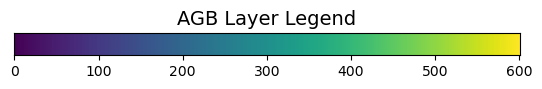

In [32]:
# AGB values range 0-600, so gradient_max = 601
plot_colormap(601, "AGB Layer Legend",'viridis')

### Reading META CHM Layer

Now, we visualize the META CHM layer with the point cloud layer.

In [33]:
chm_product_url = "s3://maap-ops-workspace/shared/omshinde23/meta_chm_new.tif"

In [34]:
chm_product_tile_url = "https://titiler.maap-project.org/cog/tiles/{z}/{x}/{y}?url=s3://maap-ops-workspace/shared/omshinde23/meta_chm_new.tif&rescale=0,60&colormap_name=viridis"

In [35]:
r_chm = httpx.get(
    f"{titiler_endpoint}/cog/info",
    params = {
        "url": chm_product_url,
    }
).json()

bounds_chm = r_chm["bounds"]
print(bounds_chm)

[-79.87929430332252, 9.122007215999078, -79.81190140986412, 9.187029513446365]


In [36]:
chm_product_layer = BitmapTileLayer(
    data=chm_product_tile_url,
    tile_size=148,
    max_requests=-1,
    min_zoom=3,
    max_zoom=18,
    extent=bounds_chm
)

In [37]:
m1 = Map([chm_product_layer, trail_layer, point_layer])
m1

Map(layers=[BitmapTileLayer(data='https://titiler.maap-project.org/cog/tiles/{z}/{x}/{y}?url=s3://maap-ops-wor…

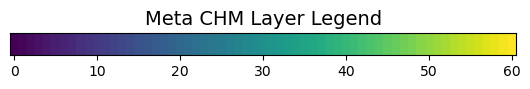

In [38]:
plot_colormap(61, "Meta CHM Layer Legend",'viridis')

### Notebook Sharing

Once the processing is complete and the notebook is ready to be shared as a resource, you can follow these steps to ensure it is accessible to a broader audience. The rendered notebook will be designed for demonstration purposes only and will not be executable. This approach is particularly valuable for presenting complex scientific notebooks to a non-technical audience in a clear and understandable way. For this, we use [Notebook Sharing](notebooksharing.space) service. Since, this notebook contains interactive visualization maps, it is a good practice to generate an executed version of this notebook before sharing so that the maps are frozen. For generating an executed notebook, following commands need to be performed.

In [39]:
# Get the list of jupyter notebook kernels 

!jupyter kernelspec list

[ListKernelSpecs] WARNING | Config option `kernel_spec_manager_class` not recognized by `ListKernelSpecs`.
Available kernels:
  python3    /opt/conda/envs/pangeo/share/jupyter/kernels/python3
  myenv      /projects/.local/share/jupyter/kernels/myenv
  pdal24     /projects/.local/share/jupyter/kernels/pdal24
  py37       /projects/.local/share/jupyter/kernels/py37
  py38       /projects/.local/share/jupyter/kernels/py38
  py39       /projects/.local/share/jupyter/kernels/py39
  vanilla    /projects/.local/share/jupyter/kernels/vanilla


In [ ]:
# Generate an executed notebook - big-EO-viz-executed.ipynb
# Use the kernel corresponding to the current environment from above, python3 in this case

!python -m nbconvert big-EO-viz.ipynb --to ipynb --stdout --execute > big-EO-viz-executed.ipynb -ExecutePreprocessor.kernel_name=python3

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook big-EO-viz.ipynb to ipynb
(PDAL Error) Can't load library /opt/conda/envs/pangeo/lib/libpdal_plugin_reader_draco.so: Failed to load "/opt/conda/envs/pangeo/lib/libpdal_plugin_reader_draco.so": libdraco.so.8: cannot open shared object file: No such file or directory(PDAL Error) Can't load library /opt/conda/envs/pangeo/lib/libpdal_plugin_writer_draco.so: Failed to load "/opt/conda/envs/pangeo/lib/libpdal_plugin_writer_draco.so": libdraco.so.8: cannot open shared object file: No such file or directory(PDAL Error) Can't load library /opt/conda/envs/pangeo/lib/libpdal_plugin_reader_draco.so: Failed to load "/opt/conda/envs/pangeo/lib/libpdal_plugin_reader_draco.so": libdraco.so.8: cannot open shared object file: No such file or directory(PDAL Error) Can't load library /opt/conda/envs/pangeo/lib/libpdal_plugin_writer_draco.so: Failed to load "/opt/conda/env

### Upload the Notebook

After executing the above cell, you can find the executed notebook in the same directory with the name `big-EO-viz-executed.ipynb`. You can upload this notebook to the [Notebook Sharing](notebooksharing.space) and get an unique URL for sharing. 